In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [15]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

In [5]:
# Check device 
# Get the GPU device name if available.
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('GPU(s) available: {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
torch.cuda.empty_cache()
    
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

GPU(s) available: 1
We will use the GPU: NVIDIA RTX A5000


In [7]:
df=pd.read_csv("data/Dataset_unsupervised.csv")
df.describe()

,Camera
count,2244.000000
mean,0.632799
std,0.482149
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


**Get to Know the Data**

In [12]:
df.groupby('Camera').describe()

Command                                                             
         count unique                                              top freq
Camera                                                                     
0          824    588        Return to base and perform a system check   13
1         1420    972  Capture image of the landing site after landing   11

<Axes: xlabel='Camera', ylabel='count'>

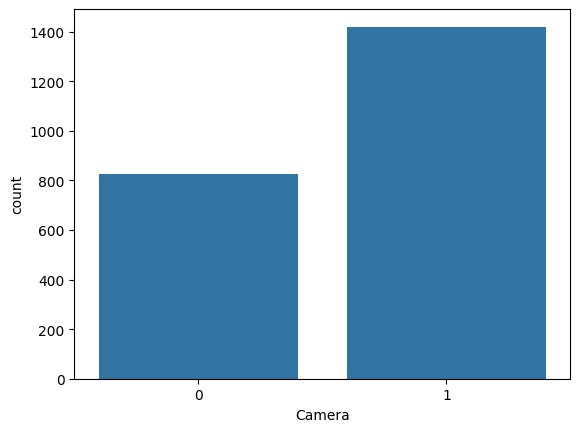

In [13]:
sns.countplot(x=df['Camera'])

[nltk_data] Downloading package stopwords to /home/tarun/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


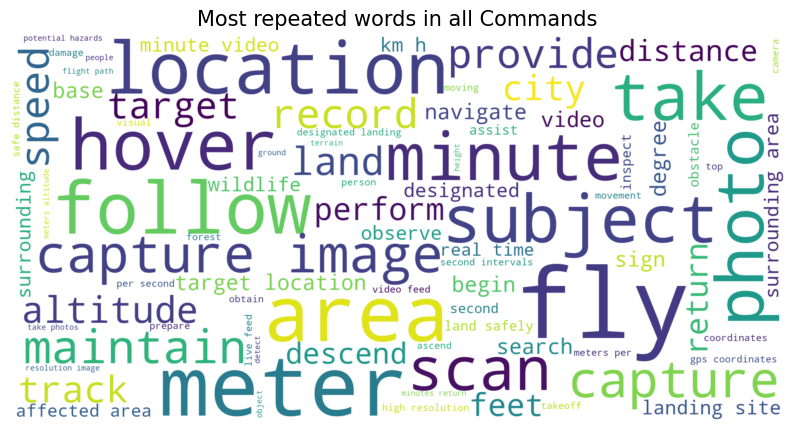

In [17]:
# Wordcloud of text

# Get stopwords
# Define nltk stopwords in english
nltk.download('stopwords')
stop_words = stopwords.words('english')
# Get a string of all the texts available
data_text = ",".join(txt.lower() for txt in df.Command)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=100, 
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(data_text)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in all Commands',fontsize=15)
plt.show()

**Downsampling data**

In [18]:
df_nocam = df[df['Camera']==0]
df_cam = df[df['Camera']==1]
df_cam_downsampled = df_cam.sample(df_nocam.shape[0])
df = pd.concat([df_cam_downsampled, df_nocam])
df.groupby('Camera').describe()

Command                                                             
         count unique                                              top freq
Camera                                                                     
0          824    588        Return to base and perform a system check   13
1          824    628  Capture image of the landing site after landing    9

In [19]:
# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['Command'], df['Camera'], test_size=0.25, shuffle=True, random_state=42)

**Try transformer model**

In [20]:
# Obtain a 10% test set from train set
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [21]:
model_name = 'bert-base-uncased'
SEQ_LEN = 200
batch_size = 16
epochs = 5
learning_rate = 1e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = 50
num_workers = 3

In [22]:
# Load the RoBERTa tokenizer and tokenize the data
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading BERT tokenizer...


/home/tarun/btp/Python/Multimodal_AI_In_Drone/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [25]:
trencoding = tokenizer.batch_encode_plus(
  list(X_train_Transformer),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(X_val_Transformer),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


testencoding = tokenizer.batch_encode_plus(
  list(x_test),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

In [26]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [27]:
trencoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

**Find Class Weights**

In [30]:
#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(df['Camera'].values.tolist()), y=df['Camera'])

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

In [31]:
def loadData(prep_df, batch_size, num_workers, sampler):
    
    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_y = torch.tensor(y_train_Transformer.tolist())

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_y = torch.tensor(y_val_Transformer.tolist())

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_y = torch.tensor(y_test.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

Number of data in the train set 62
Number of data in the validation set 16
Number of data in the test set 26


In [32]:
batch_size

16

**Load BERT model**

In [33]:
class BERT_Arch(nn.Module):
    
    def __init__(self, n_classes, freeze_bert=False):
        
        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)
        
        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
                
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)        
        return output

In [34]:
class_names = np.unique(df['Camera'])
print('Downloading the BERT custom model...')
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer 
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer 
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer 
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)

Preparing the optimizer...


/home/tarun/btp/Python/Multimodal_AI_In_Drone/venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
# function to train the bert model
def trainBERT():
  
    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(traindata):
    
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()        
        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
        
        torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [36]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")
    t0 = time.time()
    
    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(valdata):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valdata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(valdata) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [37]:
# set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = trainBERT()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    print('Evaluation done for epoch {}'.format(epoch + 1))
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_weights.pt') # Save model weight's (you can also save it in .bin format)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
Training...
  Batch    50  of     62.

Evaluating...
Evaluation done for epoch 1
Saving model...

Training Loss: 0.504
Validation Loss: 0.212

 Epoch 2 / 5
Training...
  Batch    50  of     62.

Evaluating...
Evaluation done for epoch 2
Saving model...

Training Loss: 0.232
Validation Loss: 0.177

 Epoch 3 / 5
Training...
  Batch    50  of     62.

Evaluating...
Evaluation done for epoch 3
Saving model...

Training Loss: 0.150
Validation Loss: 0.156

 Epoch 4 / 5
Training...
  Batch    50  of     62.

Evaluating...
Evaluation done for epoch 4

Training Loss: 0.115
Validation Loss: 0.168

 Epoch 5 / 5
Training...
  Batch    50  of     62.

Evaluating...
Evaluation done for epoch 5
Saving model...

Training Loss: 0.098
Validation Loss: 0.083


In [38]:
print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 3):
    
    print('\nFold Model', fold_index)
    
    # Load the fold model
    path_model = 'bert_weights.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []
    
    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_test_y = test_batch[3].to(device)


        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()
        
        #true_labels.append(b_test_y.to('cpu').numpy().flatten())
        
        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds
            
        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
            
    test_preds.append(stacked_val_preds)
    
            
print('\nPrediction complete.')


Test Set...
Total batches: 26

Fold Model 0


/tmp/ipykernel_3772227/3411321308.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_model))


Batch 26
Fold Model 1
Batch 26
Fold Model 2
Batch 26
Prediction complete.


In [39]:
print(len(test_preds))
print(test_preds[:5])

3
[array([[-4.1952524,  3.251811 ],
       [ 4.433974 , -3.2588255],
       [-4.65546  ,  3.3848486],
       [ 4.4280357, -3.2659144],
       [ 4.358476 , -3.219956 ],
       [-4.709337 ,  3.607754 ],
       [ 4.313328 , -3.218745 ],
       [-4.6317825,  3.43112  ],
       [ 4.432569 , -3.2580502],
       [-4.605304 ,  3.4574416],
       [-4.848841 ,  3.6279676],
       [ 4.382518 , -3.224508 ],
       [ 4.3907075, -3.2350347],
       [ 4.41407  , -3.2435074],
       [ 4.328773 , -3.2074208],
       [-4.3334217,  3.5322368],
       [ 4.4548483, -3.2037125],
       [-4.9333982,  3.5999777],
       [-4.8708205,  3.376644 ],
       [ 4.4187675, -3.2425947],
       [ 4.4231715, -3.2757537],
       [-4.8736963,  3.608676 ],
       [ 4.401853 , -3.2589948],
       [-4.7839494,  3.531573 ],
       [ 4.4051094, -3.2617655],
       [-4.721291 ,  3.5971558]], dtype=float32), array([[-4.1952524,  3.251811 ],
       [ 4.433974 , -3.2588255],
       [-4.65546  ,  3.3848486],
       [ 4.4280357, -3.

In [40]:
# Sum the predictions of all fold models
for i, item in enumerate(test_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(test_preds))

#print(preds)
#print()
#print(avg_preds)

# Take the argmax. 
# This returns the column index of the max value in each row.
test_predictions = np.argmax(avg_preds, axis=1)

# Take a look of the output
print(type(test_predictions))
print(len(test_predictions))
print()
print(test_predictions)

<class 'numpy.ndarray'>
26

[1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1]


In [41]:
true_y = []
for j, test_batch in enumerate(testdata):
    true_y.append(int(test_batch[3][0].numpy().flatten()))
print(true_y)

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]


/tmp/ipykernel_3772227/3331745366.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_y.append(int(test_batch[3][0].numpy().flatten()))


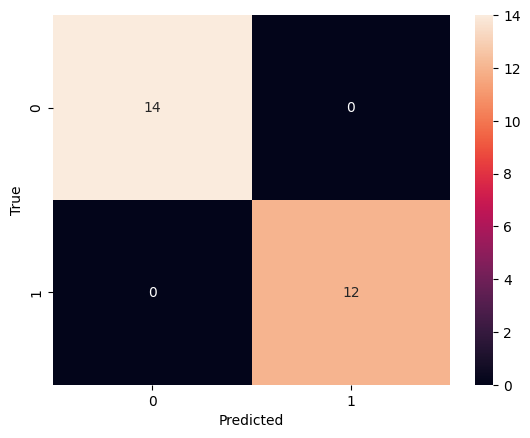

In [42]:
# Accuracy and classification report 
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': test_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [43]:
print('Accuracy of BERT model', accuracy_score(true_y, test_predictions))

Accuracy of BERT model 1.0


In [44]:
print(classification_report(true_y, test_predictions, target_names=target_names))

              precision    recall  f1-score   support

      true_y       1.00      1.00      1.00        14
 predicted_y       1.00      1.00      1.00        12

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



**Logistic Regression**

In [45]:
# Create a Pipeline with the TfidfVectorizer and LogisticRegression model
LR_pipeline = Pipeline(steps = [('tf', TfidfVectorizer()), 
                                ('lgrg', LogisticRegression())]) # initialize TfidfVectorizer and LogisticRegression


# Create Parameter Grid
pgrid_lgrg = {
 'tf__max_features' : [1000, 2000, 3000],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True, False],
 'lgrg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
 'lgrg__class_weight' : ['balanced', None]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_lgrg = GridSearchCV(LR_pipeline, pgrid_lgrg, cv=2, n_jobs=-1, verbose=2)

In [46]:
gs_lgrg.fit(x_train, y_train) # Train LR model

Fitting 2 folds for each of 96 candidates, totalling 192 fits
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=2000, tf__ngram_range=(1, 1), tf__use_idf=True; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1, 1), tf__use_idf=True; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1, 1), tf__use_idf=True; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1, 1), tf__use_idf=False; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1, 2), tf__use_idf=True; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1, 2), tf__use_idf=True; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1

/home/tarun/btp/Python/Multimodal_AI_In_Drone/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tarun/btp/Python/Multimodal_AI_In_Drone/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tarun/btp/Python/Multimodal_AI_In_Drone/venv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/tarun/btp/Python/Multimodal_AI_In_Drone/ve

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lgrg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lgrg__class_weight': ['balanced', None],
                         'lgrg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'tf__max_features': [1000, 2000, 3000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__use_idf': [True, False]},
             verbose=2)

In [47]:
gs_lgrg.best_params_

{'lgrg__class_weight': None,
 'lgrg__penalty': 'l2',
 'tf__max_features': 1000,
 'tf__ngram_range': (1, 2),
 'tf__use_idf': True}

In [48]:
print('Score of train set', gs_lgrg.score(x_train, y_train))
print('Score of test set',gs_lgrg.score(x_test, y_test))

Score of train set 0.9724919093851133
Score of test set 0.9199029126213593


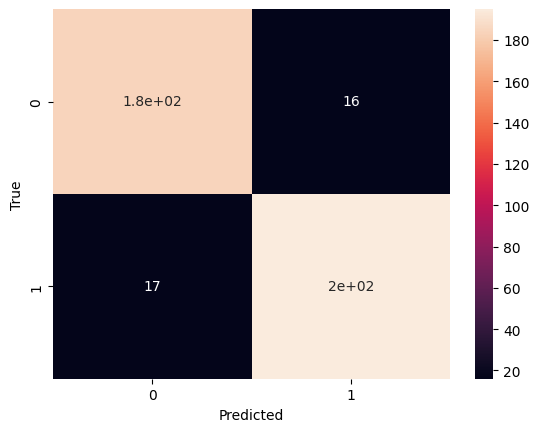

In [49]:
LR_pred = gs_lgrg.predict(x_test) # Predict on validation data

data = {'true_y': y_test,
       'predicted_y': LR_pred}
df_pred = pd.DataFrame(data, columns=['true_y','predicted_y'])
confusion_matrix = pd.crosstab(df_pred['true_y'], df_pred['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [50]:
print('Accuracy of LR model', accuracy_score(y_test, LR_pred))

Accuracy of LR model 0.9199029126213593


In [51]:
print(classification_report(y_test, LR_pred, target_names=target_names))

              precision    recall  f1-score   support

      true_y       0.92      0.92      0.92       200
 predicted_y       0.92      0.92      0.92       212

    accuracy                           0.92       412
   macro avg       0.92      0.92      0.92       412
weighted avg       0.92      0.92      0.92       412

